In [1]:
import json
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import lxml
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from pandas import json_normalize
import matplotlib
import matplotlib.pyplot as plt
import mplsoccer
from mplsoccer import Pitch, VerticalPitch, FontManager
import seaborn as sns
import numpy as np
chrome_driver_path = r"C:\Users\Al Raven\anaconda3\Lib\site-packages\selenium\webdriver\chrome\chromedriver.exe"

In [2]:
# Initialize the WebDriver
driver = webdriver.Chrome()

# List of links to scrape
links = ['https://www.whoscored.com/Matches/1703222/Live/Argentina-Liga-Profesional-2023-Argentinos-Juniors-Estudiantes',
        'https://www.whoscored.com/Matches/1703218/Live/Argentina-Liga-Profesional-2023-San-Lorenzo-Argentinos-Juniors',
        'https://www.whoscored.com/Matches/1703256/Live/Argentina-Liga-Profesional-2023-Argentinos-Juniors-Colon',
        'https://www.whoscored.com/Matches/1703417/Live/Argentina-Liga-Profesional-2023-Barracas-Central-Argentinos-Juniors',
        'https://www.whoscored.com/Matches/1703270/Live/Argentina-Liga-Profesional-2023-Argentinos-Juniors-Instituto',
        'https://www.whoscored.com/Matches/1703153/Live/Argentina-Liga-Profesional-2023-Banfield-Argentinos-Juniors',
        'https://www.whoscored.com/Matches/1703371/Live/Argentina-Liga-Profesional-2023-Argentinos-Juniors-Club-Atletico-Platense',
        'https://www.whoscored.com/Matches/1703148/Live/Argentina-Liga-Profesional-2023-Velez-Sarsfield-Argentinos-Juniors',
        'https://www.whoscored.com/Matches/1703116/Live/Argentina-Liga-Profesional-2023-Argentinos-Juniors-Defensa-y-Justicia',
        'https://www.whoscored.com/Matches/1703337/Live/Argentina-Liga-Profesional-2023-Argentinos-Juniors-Independiente',
        'https://www.whoscored.com/Matches/1703330/Live/Argentina-Liga-Profesional-2023-Atletico-Tucuman-Argentinos-Juniors',
        'https://www.whoscored.com/Matches/1703410/Live/Argentina-Liga-Profesional-2023-Argentinos-Juniors-Boca-Juniors',
        'https://www.whoscored.com/Matches/1703375/Live/Argentina-Liga-Profesional-2023-Talleres-Argentinos-Juniors',
        'https://www.whoscored.com/Matches/1703266/Live/Argentina-Liga-Profesional-2023-Sarmiento-Argentinos-Juniors',
        'https://www.whoscored.com/Matches/1703326/Live/Argentina-Liga-Profesional-2023-Argentinos-Juniors-Union',
        'https://www.whoscored.com/Matches/1703313/Live/Argentina-Liga-Profesional-2023-Huracan-Argentinos-Juniors',
        'https://www.whoscored.com/Matches/1703321/Live/Argentina-Liga-Profesional-2023-Argentinos-Juniors-Gimnasia-LP',
        'https://www.whoscored.com/Matches/1703367/Live/Argentina-Liga-Profesional-2023-Newell-s-Old-Boys-Argentinos-Juniors',
        'https://www.whoscored.com/Matches/1694356/Live/Argentina-Liga-Profesional-2023-Rosario-Central-Argentinos-Juniors',
        'https://www.whoscored.com/Matches/1703162/Live/Argentina-Liga-Profesional-2023-Tigre-Argentinos-Juniors',
        'https://www.whoscored.com/Matches/1703160/Live/Argentina-Liga-Profesional-2023-Argentinos-Juniors-Arsenal-Sarandi',
        'https://www.whoscored.com/Matches/1703227/Live/Argentina-Liga-Profesional-2023-Lanus-Argentinos-Juniors',
        'https://www.whoscored.com/Matches/1703236/Live/Argentina-Liga-Profesional-2023-Argentinos-Juniors-Godoy-Cruz',
        'https://www.whoscored.com/Matches/1703094/Live/Argentina-Liga-Profesional-2023-Argentinos-Juniors-Racing-Club',
        'https://www.whoscored.com/Matches/1703073/Live/Argentina-Liga-Profesional-2023-River-Plate-Argentinos-Juniors',
        'https://www.whoscored.com/Matches/1703170/Live/Argentina-Liga-Profesional-2023-Argentinos-Juniors-Belgrano',
        'https://www.whoscored.com/Matches/1703185/Live/Argentina-Liga-Profesional-2023-Central-Cordoba-de-Santiago-Argentinos-Juniors']


# DataFrame to store the scraped data
df1 = pd.DataFrame()

# Initialize WebDriverWait
wait = WebDriverWait(driver, 20)

for link in links:
    driver.get(link)
    
    # Close ad or accept cookies (modify as per the actual element)
    try:
        close_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@id="some-button-id"]')))
        close_button.click()
    except Exception as e:
        print(f"Error while clicking close button: {e}")

    # Wait for the overlay to disappear
    wait.until(EC.invisibility_of_element((By.ID, 'qc-cmp2-ui')))
    
    # Click on the match centre (modify as per the actual element)
    try:
        match_centre = wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@id="sub-navigation"]/ul/li[4]/a')))
        match_centre.click()
    except Exception as e:
        print(f"Error while clicking match centre: {e}")

    # Extract and process the script content
    try:
        element = wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="layout-wrapper"]/script[1]')))
        script_content = element.get_attribute('innerHTML')
        script_ls = script_content.split(sep="  ")
        script_ls = list(filter(None, script_ls))
        script_ls = [name for name in script_ls if name.strip()]
        dictstring = script_ls[2][17:-2]
        content = json.loads(dictstring)
        match = json_normalize(content['events'], sep='_')
        homepl = json_normalize(content['home']['players'], sep='_')[['name', 'position', 'shirtNo', 'playerId']]
        awaypl = json_normalize(content['away']['players'], sep='_')[['name', 'position', 'shirtNo', 'playerId']]
        players = pd.concat([homepl, awaypl])
        match = match.merge(players, how='left')
        df1 = pd.concat([df1, match])
    except Exception as e:
        print(f"Error while processing script content: {e}")

# Close the WebDriver session after all links are processed
driver.quit()

# df1 now contains the concatenated data from all links


Error while clicking close button: Message: 
Stacktrace:
	GetHandleVerifier [0x00007FF654EF2142+3514994]
	(No symbol) [0x00007FF654B10CE2]
	(No symbol) [0x00007FF6549B76AA]
	(No symbol) [0x00007FF654A01860]
	(No symbol) [0x00007FF654A0197C]
	(No symbol) [0x00007FF654A44EE7]
	(No symbol) [0x00007FF654A2602F]
	(No symbol) [0x00007FF654A428F6]
	(No symbol) [0x00007FF654A25D93]
	(No symbol) [0x00007FF6549F4BDC]
	(No symbol) [0x00007FF6549F5C64]
	GetHandleVerifier [0x00007FF654F1E16B+3695259]
	GetHandleVerifier [0x00007FF654F76737+4057191]
	GetHandleVerifier [0x00007FF654F6E4E3+4023827]
	GetHandleVerifier [0x00007FF654C404F9+689705]
	(No symbol) [0x00007FF654B1C048]
	(No symbol) [0x00007FF654B18044]
	(No symbol) [0x00007FF654B181C9]
	(No symbol) [0x00007FF654B088C4]
	BaseThreadInitThunk [0x00007FF9FC44257D+29]
	RtlUserThreadStart [0x00007FF9FC96AA58+40]

Error while clicking close button: Message: 
Stacktrace:
	GetHandleVerifier [0x00007FF654EF2142+3514994]
	(No symbol) [0x00007FF654B10CE2]

Error while clicking close button: Message: 
Stacktrace:
	GetHandleVerifier [0x00007FF654EF2142+3514994]
	(No symbol) [0x00007FF654B10CE2]
	(No symbol) [0x00007FF6549B76AA]
	(No symbol) [0x00007FF654A01860]
	(No symbol) [0x00007FF654A0197C]
	(No symbol) [0x00007FF654A44EE7]
	(No symbol) [0x00007FF654A2602F]
	(No symbol) [0x00007FF654A428F6]
	(No symbol) [0x00007FF654A25D93]
	(No symbol) [0x00007FF6549F4BDC]
	(No symbol) [0x00007FF6549F5C64]
	GetHandleVerifier [0x00007FF654F1E16B+3695259]
	GetHandleVerifier [0x00007FF654F76737+4057191]
	GetHandleVerifier [0x00007FF654F6E4E3+4023827]
	GetHandleVerifier [0x00007FF654C404F9+689705]
	(No symbol) [0x00007FF654B1C048]
	(No symbol) [0x00007FF654B18044]
	(No symbol) [0x00007FF654B181C9]
	(No symbol) [0x00007FF654B088C4]
	BaseThreadInitThunk [0x00007FF9FC44257D+29]
	RtlUserThreadStart [0x00007FF9FC96AA58+40]

Error while clicking close button: Message: 
Stacktrace:
	GetHandleVerifier [0x00007FF654EF2142+3514994]
	(No symbol) [0x00007FF654B10CE2]

Error while clicking close button: Message: 
Stacktrace:
	GetHandleVerifier [0x00007FF654EF2142+3514994]
	(No symbol) [0x00007FF654B10CE2]
	(No symbol) [0x00007FF6549B76AA]
	(No symbol) [0x00007FF654A01860]
	(No symbol) [0x00007FF654A0197C]
	(No symbol) [0x00007FF654A44EE7]
	(No symbol) [0x00007FF654A2602F]
	(No symbol) [0x00007FF654A428F6]
	(No symbol) [0x00007FF654A25D93]
	(No symbol) [0x00007FF6549F4BDC]
	(No symbol) [0x00007FF6549F5C64]
	GetHandleVerifier [0x00007FF654F1E16B+3695259]
	GetHandleVerifier [0x00007FF654F76737+4057191]
	GetHandleVerifier [0x00007FF654F6E4E3+4023827]
	GetHandleVerifier [0x00007FF654C404F9+689705]
	(No symbol) [0x00007FF654B1C048]
	(No symbol) [0x00007FF654B18044]
	(No symbol) [0x00007FF654B181C9]
	(No symbol) [0x00007FF654B088C4]
	BaseThreadInitThunk [0x00007FF9FC44257D+29]
	RtlUserThreadStart [0x00007FF9FC96AA58+40]

Error while clicking close button: Message: 
Stacktrace:
	GetHandleVerifier [0x00007FF654EF2142+3514994]
	(No symbol) [0x00007FF654B10CE2]

In [3]:
player_name = 'Federico Redondo'

In [4]:
player_team = 'Argentinos Juniors'

In [28]:
player_appearances = '21 appearances, 8 90\'s'

In [6]:
competition_date = 'Primera División, 2023'

In [7]:
#leave empty if it's for one or more full season(s)
data_valid = ''

In [8]:
player_df = df1.loc[df1['name']==player_name].copy()

In [9]:
player_passes = player_df.loc[player_df['type_displayName']=='Pass'].copy()

In [10]:
#passes IN opponent's half
player_opphalf_passes = player_passes[player_passes['x']>=50]
#passes in their own half
player_ownhalf_passes = player_passes[player_passes['x']<50]
#passes INTO the final third
player_final_3rd_passes = player_passes[player_passes['endX']>=66]
player_final_3rd_passes = player_final_3rd_passes[player_final_3rd_passes['x']<=66]
#completed passes into the final third
player_comp_final3rd_passes = player_final_3rd_passes[player_final_3rd_passes['outcomeType_displayName']=='Successful']
#passes into the opponent's box
player_passes_intobox = player_passes[player_passes['endX']>=85]
player_passes_intobox = player_passes_intobox[player_passes_intobox['endY']<=80]
player_passes_intobox = player_passes_intobox[player_passes_intobox['endY']>=20]
player_passes_intobox = player_passes_intobox[player_passes_intobox['x']<82.9]
#completed/successful passes into the opponent's box
player_comp_passes_intobox = player_passes_intobox[player_passes_intobox['outcomeType_displayName']=='Successful']

#take-ons/dribbles
player_dribbles = player_df.loc[player_df['type_displayName']=='TakeOn'].copy()
#touches
player_touches = player_df.loc[player_df['isTouch']==True].copy()
player_touches2 = player_df.loc[player_df['type_displayName']=='BallTouch'].copy()
#dispossessions
player_dispossessions = player_df.loc[player_df['type_displayName']=='Dispossessed'].copy()
#shots
player_shots = player_df.loc[player_df['isShot']==True].copy()
#goals
player_goals = player_df.loc[player_df['isGoal']==True].copy()
#tackles
player_tackles = player_df.loc[player_df.type_displayName=='Tackle'].copy()
#challenges
player_challenges = player_df.loc[player_df.type_displayName=='Challenge'].copy()
#clearances
player_clearances = player_df.loc[player_df.type_displayName=='Clearance'].copy()
#recoveries
player_recoveries = player_df.loc[player_df.type_displayName=='BallRecovery'].copy()
#blocked passes
player_blocked_passes = player_df.loc[player_df.type_displayName=='BlockedPass'].copy()
#interceptions
player_interceptions = player_df.loc[player_df.type_displayName=='Interception'].copy()
#aerial duels
player_aerials = player_df.loc[player_df['type_displayName']=='Aerial'].copy()
#all defensive actions: 
player_defensive_actions = player_df.loc[(player_df.type_displayName=='Challenge') |  
        (player_df.type_displayName=='BlockedPass')|
        (player_df.type_displayName=='Tackle')|
        (player_df.type_displayName=='Interception')|
        (player_df.type_displayName=='Aerial')|
        (player_df.type_displayName=='Foul')].copy()

In [11]:
player_passes['beginning'] = np.sqrt(np.square(100 - player_passes['x']) + np.square(50 - player_passes['y']))
player_passes['end'] = np.sqrt(np.square(100 - player_passes['endX']) + np.square(50 - player_passes['endY']))
player_passes.loc[:, 'progressive'] = (player_passes['end'] / player_passes['beginning'] < 0.75) & (player_passes['x']<player_passes['endX'])
player_progressive_passes = player_passes[player_passes['progressive']==True]

Text(0.3, 0.1, 'Data: Opta')

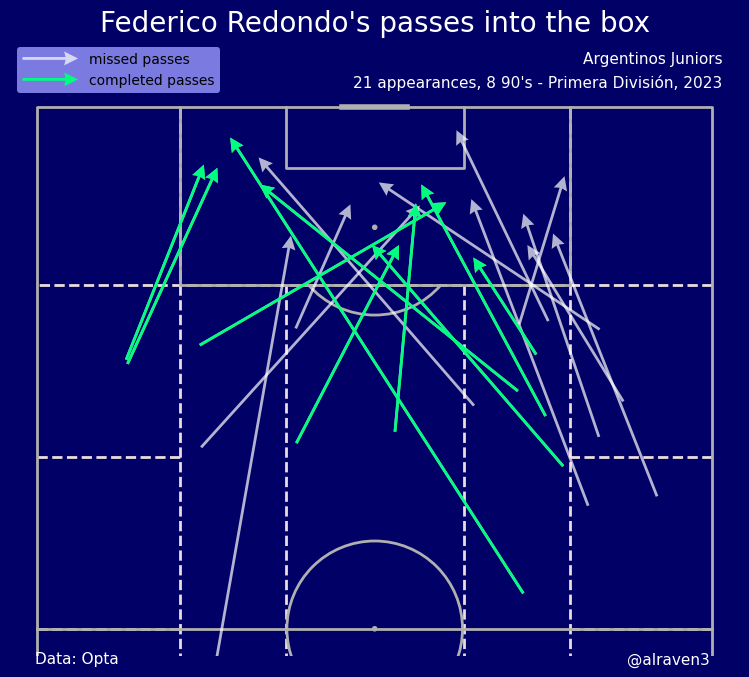

In [92]:
pitch = VerticalPitch(positional=True, pitch_type='opta', half=True, 
                      pitch_color='#000066', positional_linestyle='--',pad_top=10)
fig, ax = pitch.draw(figsize=(16, 8), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#000066')
# Plot the completed passes
pitch.arrows(player_passes_intobox.x, player_passes_intobox.y,
             player_passes_intobox.endX, player_passes_intobox.endY, width=2,
             headwidth=5, headlength=5, color='white',alpha=.7, label='missed passes',ax=ax)
pitch.arrows(player_comp_passes_intobox.x, player_comp_passes_intobox.y,
             player_comp_passes_intobox.endX, player_comp_passes_intobox.endY, width=2,
             headwidth=5, headlength=5, color='springgreen', label='completed passes', ax=ax)
ax.legend(facecolor='#9999ff', edgecolor='None', fontsize=10, loc='upper left', handlelength=4)
ax_title = ax.set_title(f"{player_name}'s passes into the box", fontsize=20,color='white')
fig.text(0.73,0.85,f"{player_team}",ha='right',color='white',size=11)
fig.text(0.73,0.82,f"{player_appearances} - {competition_date}",ha='right',color='white',size=11)
fig.text(0.67,0.1,'@alraven3',color='white',size=11)
fig.text(0.46,0.1,f"{data_valid}",color='white',size=11)
fig.text(0.3,0.1,'Data: Opta',color='white',size=11)

Text(0.28, 0.1, 'Data: Opta')

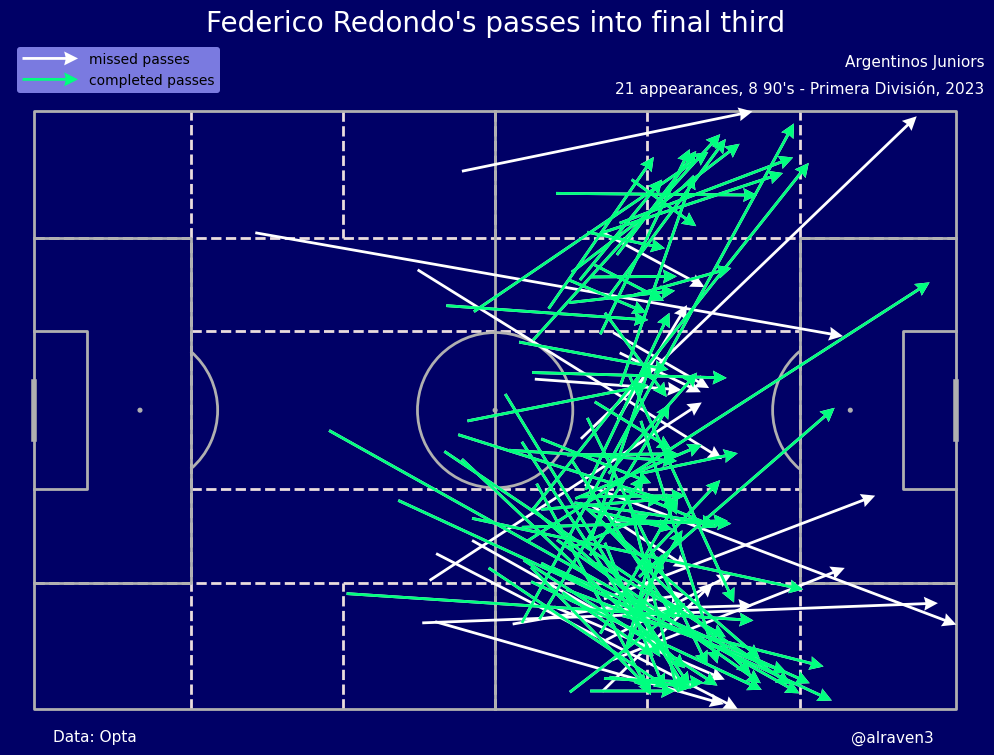

In [30]:
pitch = Pitch(positional=True, pitch_type='opta', 
                      pitch_color='#000066', positional_linestyle='--',pad_top=12)
fig, ax = pitch.draw(figsize=(19, 9), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#000066')
# Plot the completed passes
pitch.arrows(player_final_3rd_passes.x, player_final_3rd_passes.y,
             player_final_3rd_passes.endX, player_final_3rd_passes.endY, width=2,
             headwidth=5, headlength=5, color='white', label='missed passes',ax=ax)
pitch.arrows(player_comp_final3rd_passes.x, player_comp_final3rd_passes.y,
             player_comp_final3rd_passes.endX, player_comp_final3rd_passes.endY, width=2,
             headwidth=5, headlength=5, color='springgreen', label='completed passes', ax=ax)
ax.legend(facecolor='#9999ff', edgecolor='None', fontsize=10, loc='upper left', handlelength=4)
ax_title = ax.set_title(f"{player_name}'s passes into final third", fontsize=20,color='white')
fig.text(0.77,0.85,f"{player_team}",ha='right',color='white',size=11)
fig.text(0.77,0.82,f"{player_appearances} - {competition_date}",ha='right',color='white',size=11)
fig.text(0.7,0.1,'@alraven3',color='white',size=11)
fig.text(0.47,0.1,f"{data_valid}",color='white',size=11)
fig.text(0.28,0.1,'Data: Opta',color='white',size=11)

Text(0.18, 0.1, 'Data: Opta')

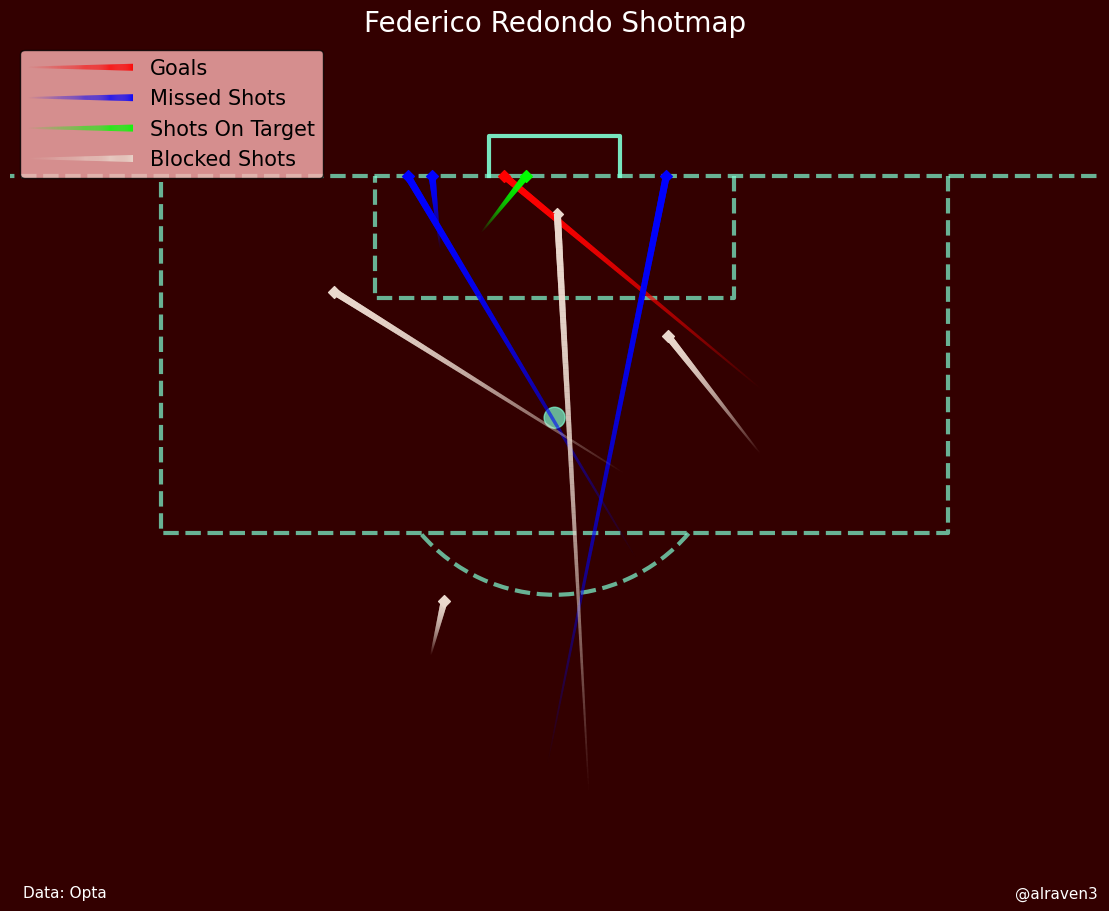

In [31]:
pitch = VerticalPitch(pitch_type='opta', pitch_color='#330000', half=True,
                      pad_left=-10,pad_right=-10,pad_top=10,pad_bottom=-25,
                      spot_scale=0.005,linewidth=3,line_alpha=0.7, goal_alpha=0.9,
                      goal_type='box',linestyle='--',line_color='aquamarine')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)

df_missed_shots = df1.loc[df1['type_displayName']=='MissedShots']
player_missed = df_missed_shots.loc[df_missed_shots['name']==player_name]
# Update 'endX' column for unblocked shots
player_shots.loc[player_shots['blockedX'].isna(), 'endX'] = 100
player_goals.loc[player_goals['blockedX'].isna(), 'endX'] = 100
player_missed.loc[player_missed['blockedX'].isna(), 'endX'] = 100

# Differentiate between blocked shots, goals, on-target shots, and missed shots
player_shots['on_target'] = np.where((player_shots['endX'] >= 100) & (player_shots['goalMouthY'] >= 45) & (player_shots['goalMouthY'] <= 55), True, False)
player_shots['missed'] = ~player_shots['on_target']

# Plot goals as red arrows
pitch.scatter(player_goals['endX'], player_goals['goalMouthY'],marker='D',color='red',ax=ax)
pitch.lines(player_goals['x'], player_goals['y'], player_goals['endX'], player_goals['goalMouthY'], comet=True,
            transparent=True, color='red', label='Goals',ax=ax)

# Plot missed shots (off target) as blue arrows
#missed_shots = h_shots[(h_shots['missed']) & (h_shots['isGoal'] != 1)]
pitch.scatter(player_missed.endX,player_missed.goalMouthY,color='blue',marker='D',ax=ax)
#pitch.arrows(missed_shots['x'], missed_shots['y'], missed_shots['endX'], missed_shots['goalMouthY'],
#             width=2, headwidth=10, headlength=10, color='blue', label='Missed Shots', ax=ax)
pitch.lines(player_missed.x,player_missed.y,player_missed.endX,player_missed.goalMouthY,
             comet=True, transparent=True, color='blue', label='Missed Shots', ax=ax)

# Plot on-target shots as green arrows (excluding goals)
on_target_shots = player_shots[(player_shots['on_target']) & (player_shots['isGoal'] != 1)]
pitch.scatter(on_target_shots['endX'], on_target_shots['goalMouthY'],color='lime',marker='D',ax=ax)
pitch.lines(on_target_shots['x'], on_target_shots['y'], on_target_shots['endX'], on_target_shots['goalMouthY'],
             comet=True, transparent=True,  color='lime', label='Shots On Target', ax=ax)

# Plot blocked shots as black arrows
blocked_shots = player_shots[player_shots['blockedX'].notna()]
#pitch.scatter(blocked_shots['x'], blocked_shots['y'],color='black',ax=ax)
pitch.scatter(blocked_shots['blockedX'], blocked_shots['blockedY'],marker='D',color='#ead8cd',ax=ax)
pitch.lines(blocked_shots['x'], blocked_shots['y'], blocked_shots['blockedX'], blocked_shots['blockedY'],
             comet=True, transparent=True, color='#ead8cd', label='Blocked Shots',ax=ax)
#title
fig.set_facecolor('#330000')
ax_title = ax.set_title(f"{player_name} Shotmap", fontsize=20,color='white')

# Add a legend to the plot
ax.legend(facecolor='#ffb3b3', edgecolor='black',labelcolor='black',fontsize=15,loc='upper left', handlelength=5)
fig.text(0.8,0.1,'@alraven3',color='white',size=11)
fig.text(0.46,0.1,f"{data_valid}",color='white',size=11)
fig.text(0.18,0.1,'Data: Opta',color='white',size=11)

Text(0.18, 0.1, 'Data: Opta')

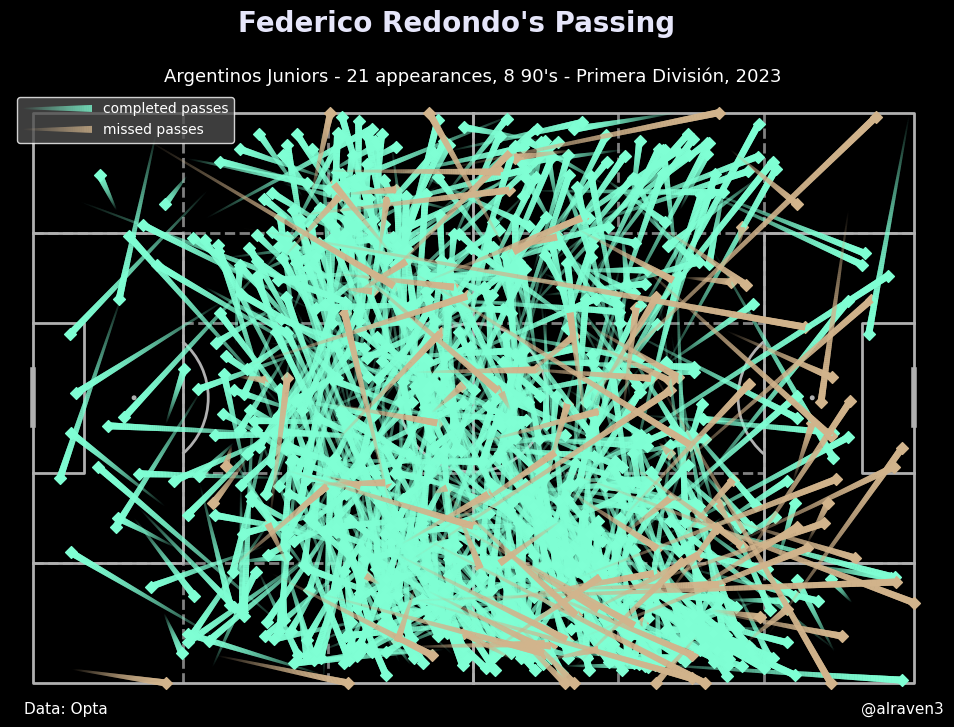

In [32]:
player_successfulPasses = player_passes[player_passes['outcomeType_displayName']=='Successful']
player_otherPasses = player_passes[player_passes['outcomeType_displayName']=='Unsuccessful']
pitch = Pitch(positional=True,pitch_type='opta', positional_color='grey', positional_linestyle='--', 
              shade_color='#4d4d4d', pitch_color='#000000')
fig, ax = pitch.draw(figsize=(13.5, 8), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#000000')
pitch.scatter(player_successfulPasses.endX, player_successfulPasses.endY,color='aquamarine',marker='D',ax=ax)
pitch.lines(player_successfulPasses.x, player_successfulPasses.y,
             player_successfulPasses.endX, player_successfulPasses.endY, 
            comet=True, transparent=True, color='aquamarine', label='completed passes',ax=ax)
pitch.scatter(player_otherPasses.endX, player_otherPasses.endY,color='tan',marker='D',ax=ax)
pitch.lines(player_otherPasses.x, player_otherPasses.y,
             player_otherPasses.endX, player_otherPasses.endY, 
            comet=True, transparent=True, color='tan', label='missed passes', ax=ax)
ax.legend(facecolor='#4d4d4d', edgecolor='white',fontsize=10, labelcolor='white',loc='upper left', handlelength=5)
plt.suptitle(f"{player_name}'s Passing",size=20,color='lavender',fontweight='bold')
plt.title(f"{player_team} - {player_appearances} - {competition_date}",size=13,color='white')
fig.text(0.8,0.1,'@alraven3',color='white',size=11)
fig.text(0.46,0.1,f"{data_valid}",color='white',size=11)
fig.text(0.18,0.1,'Data: Opta',color='white',size=11)

Text(0.18, 0.1, 'Data: Opta')

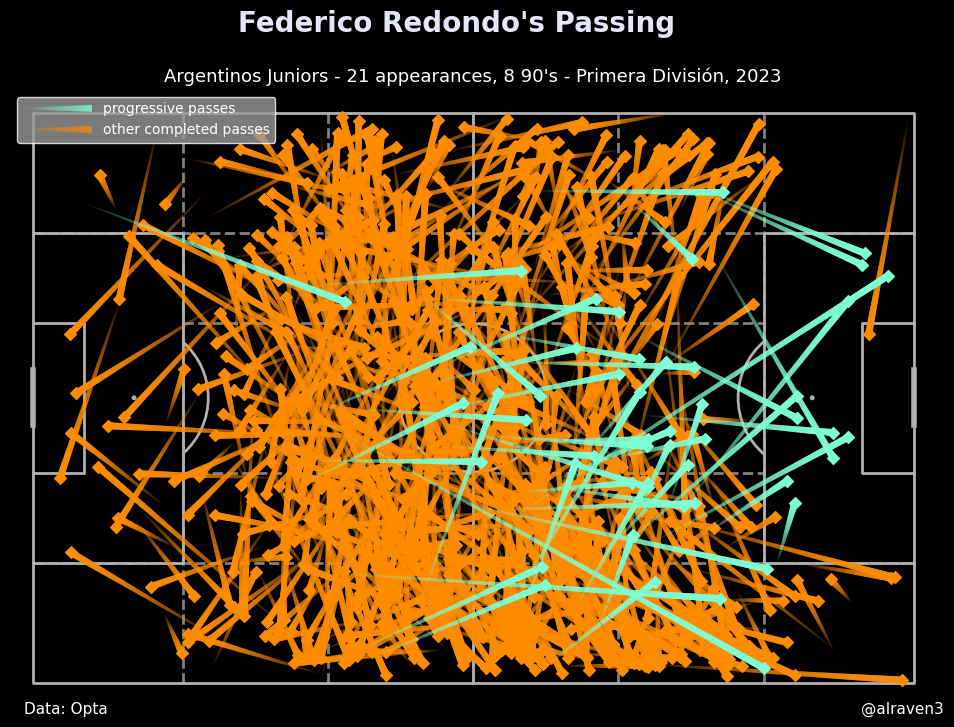

In [33]:
player_prog_passes = player_successfulPasses[player_successfulPasses['progressive']==True]
other_passes = player_successfulPasses[player_successfulPasses['progressive']==False]
pitch = Pitch(positional=True,pitch_type='opta', positional_color='grey', 
              positional_linestyle='--', pitch_color='#000000')
fig, ax = pitch.draw(figsize=(13.5, 8), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#000000')
pitch.scatter(player_prog_passes.endX, player_prog_passes.endY,color='aquamarine',marker='D',zorder=3,ax=ax)
pitch.lines(player_prog_passes.x, player_prog_passes.y,
             player_prog_passes.endX, player_prog_passes.endY,
             comet=True, transparent=True,label='progressive passes',color='aquamarine', zorder=3,ax=ax)
pitch.scatter(other_passes.endX, other_passes.endY,color='darkorange',marker='D',ax=ax)
pitch.lines(other_passes.x, other_passes.y,
             other_passes.endX, other_passes.endY,
             comet=True, transparent=True,color='darkorange',label='other completed passes',ax=ax)
ax.legend(facecolor='#999999', edgecolor='white',labelcolor='white',fontsize=10,loc='upper left', handlelength=5)
plt.suptitle(f"{player_name}'s Passing",size=20,color='lavender',fontweight='bold')
plt.title(f"{player_team} - {player_appearances} - {competition_date}",size=13,color='white')
fig.text(0.8,0.1,'@alraven3',color='white',size=11)
fig.text(0.46,0.1,f"{data_valid}",color='white',size=11)
fig.text(0.18,0.1,'Data: Opta',color='white',size=11)

Text(0.18, 0.1, 'Data: Opta')

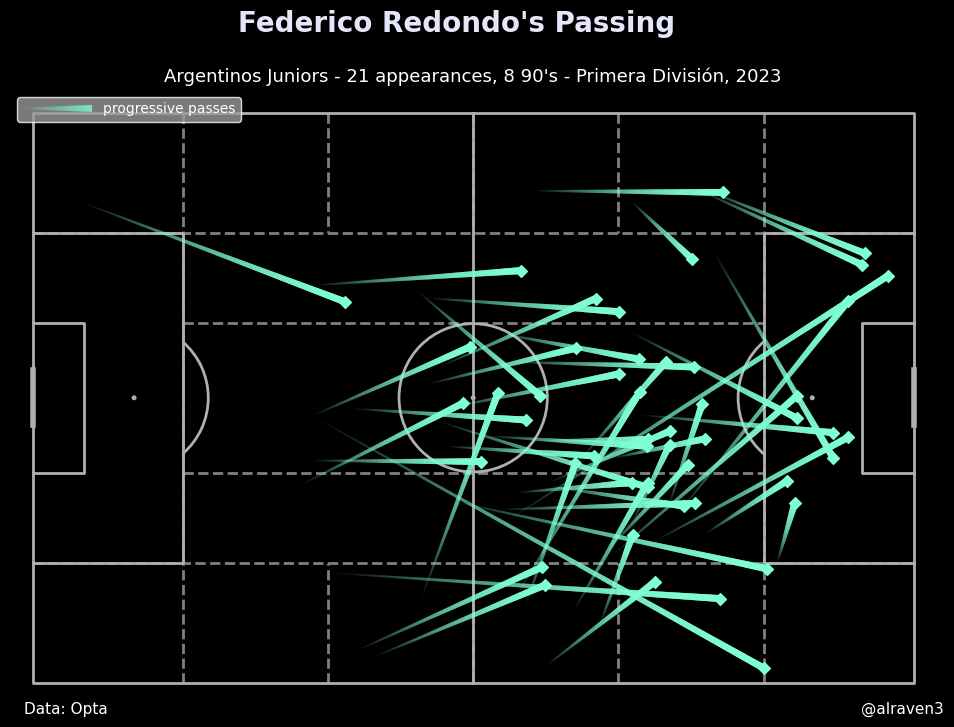

In [77]:
pitch = Pitch(positional=True,pitch_type='opta', positional_color='grey', 
              positional_linestyle='--', pitch_color='#000000')
fig, ax = pitch.draw(figsize=(13.5, 8), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#000000')
pitch.scatter(player_prog_passes.endX, player_prog_passes.endY,color='aquamarine',marker='D',zorder=3,ax=ax)
pitch.lines(player_prog_passes.x, player_prog_passes.y,
             player_prog_passes.endX, player_prog_passes.endY,
             comet=True, transparent=True,label='progressive passes',color='aquamarine', zorder=3,ax=ax)
ax.legend(facecolor='#999999', edgecolor='white',labelcolor='white',fontsize=10,loc='upper left', handlelength=5)
plt.suptitle(f"{player_name}'s Passing",size=20,color='lavender',fontweight='bold')
plt.title(f"{player_team} - {player_appearances} - {competition_date}",size=13,color='white')
fig.text(0.8,0.1,'@alraven3',color='white',size=11)
fig.text(0.46,0.1,f"{data_valid}",color='white',size=11)
fig.text(0.18,0.1,'Data: Opta',color='white',size=11)

Hexbins (technically a heatmap...)

Text(0.1, 0.02, 'Data: Opta')

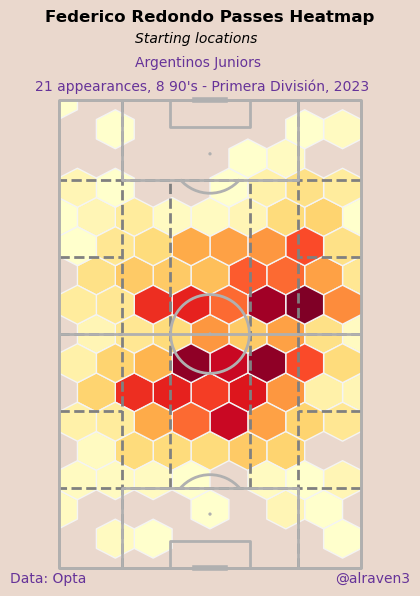

In [50]:
pitch = VerticalPitch(positional=True,pitch_type='opta', positional_color='grey', 
                      positional_linestyle='--', line_zorder=2,positional_zorder=1.5,
                      pitch_color='#ead8cd',pad_top=23)
fig, ax = pitch.draw(figsize=(5, 6))
fig.set_facecolor('#ead8cd')

hexmap = pitch.hexbin(player_passes.x, player_passes.y, ax=ax, edgecolors='#f4f4f4',
                      gridsize=(8, 8), cmap='YlOrRd')
ax.set_title(f"{player_name} Passes Heatmap",color='black',fontweight='bold')
fig.text(0.35, 0.92, "Starting locations",color='black',style='italic')
fig.text(0.15, 0.84, f"{player_appearances} - {competition_date}",color='rebeccapurple')
fig.text(0.35, 0.88, f"{player_team}",color='rebeccapurple')
fig.text(0.75,0.02,'@alraven3',color='rebeccapurple')
fig.text(0.35,0.02,f"{data_valid}",color='rebeccapurple')
fig.text(0.1,0.02,'Data: Opta',color='rebeccapurple')

Convex hull

https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_convex_hull.html#sphx-glr-gallery-pitch-plots-plot-convex-hull-py

Text(0.04, 0.03, 'Data: Opta')

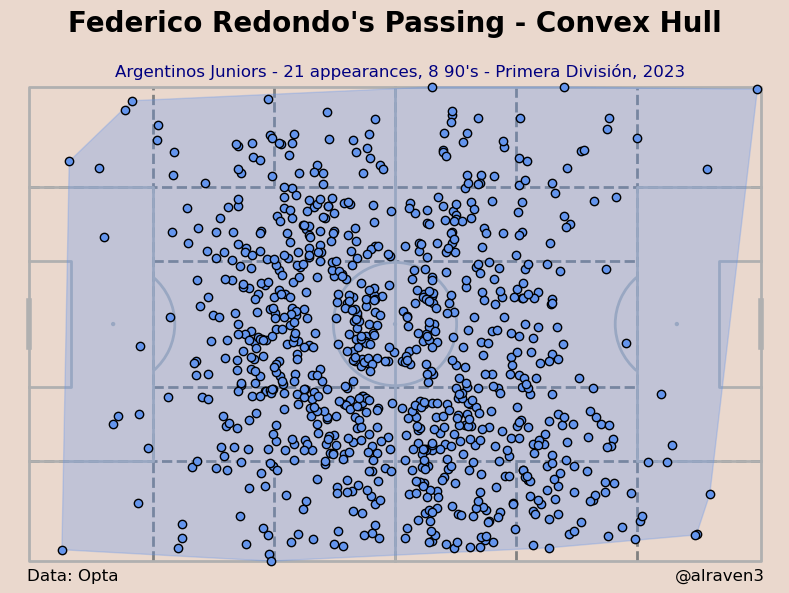

In [87]:
pitch = Pitch(positional=True,pitch_type='opta', positional_color='grey', 
              positional_linestyle='--', pitch_color='#ead8cd',pad_top=10)
fig, ax = pitch.draw(figsize=(8, 6))
fig.set_facecolor('#ead8cd')
hull = pitch.convexhull(player_passes.x, player_passes.y)
poly = pitch.polygon(hull, ax=ax, edgecolor='cornflowerblue', facecolor='cornflowerblue', alpha=0.3)
scatter = pitch.scatter(player_passes.x, player_passes.y, ax=ax, edgecolor='black', facecolor='cornflowerblue')
ax_title = ax.set_title(f"{player_name}'s Passing - Convex Hull", fontsize=20, color='black',fontweight='bold')
fig.text(0.15, 0.87, f"{player_team} - {player_appearances} - {competition_date}",color='navy',size=12)
fig.text(0.85,0.03,'@alraven3',color='black',size=12)
fig.text(0.4,0.03,f"{data_valid}",color='black',size=12)
fig.text(0.04,0.03,'Data: Opta',color='black',size=12)

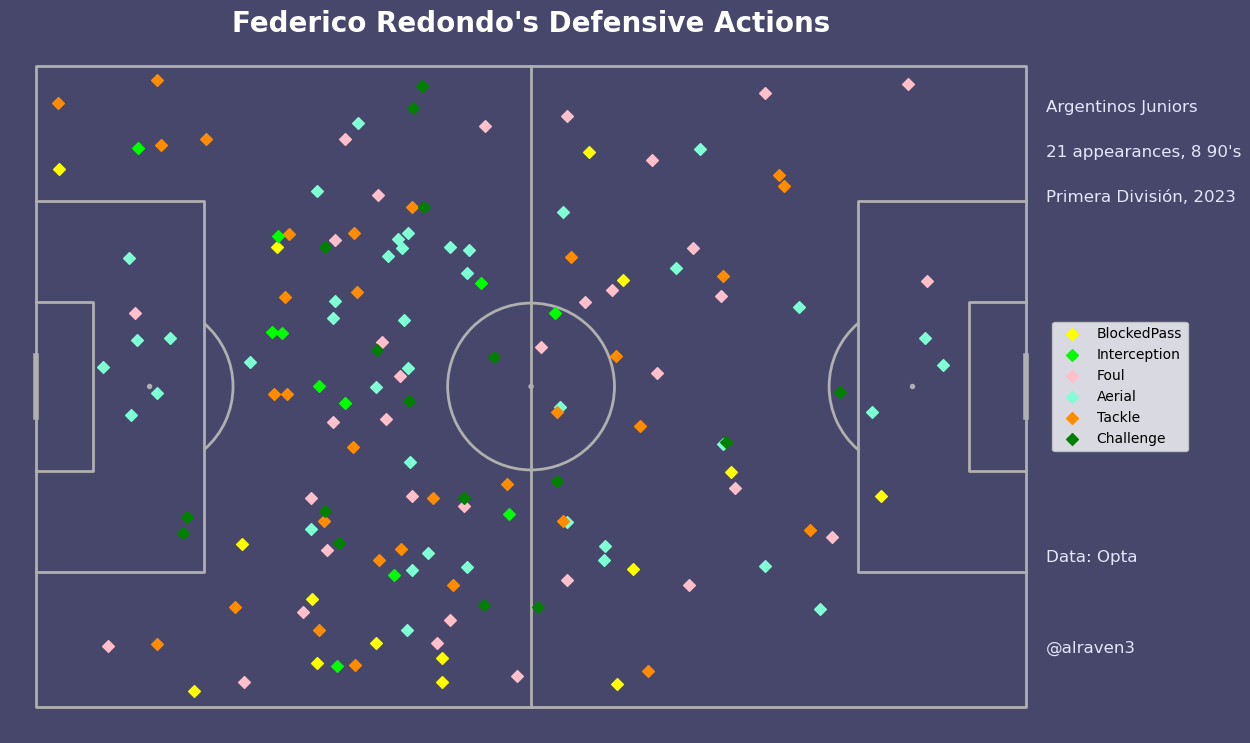

In [86]:
# Define a dictionary for action types and colors
action_colors = {
    'BlockedPass': 'yellow',
    'Interception': 'lime',
    'Foul': 'pink',
    'Aerial': 'aquamarine',
    'Tackle': 'darkorange',
    'Challenge': 'green', 
}

# Initialize the pitch
pitch = Pitch(pitch_type='opta', pitch_color='#47476b')
fig, ax = pitch.draw(figsize=(14, 9), constrained_layout=True, tight_layout=False)

# Iterate over action types and plot
for action_type, color in action_colors.items():
    action_data = player_defensive_actions[player_defensive_actions['type_displayName'] == action_type]
    if not action_data.empty:
        pitch.scatter(action_data.x, action_data.y, color=color, label=action_type,marker='D',ax=ax)

# Legend and title
#ax.legend(facecolor='#ead8cd', edgecolor='black', labelcolor='black', fontsize=12, loc='upper right', handlelength=5)
#fig.legend(facecolor='#ead8cd', edgecolor='black', labelcolor='black', fontsize=12, loc='outside upper right', handlelength=5)
plt.legend(bbox_to_anchor=(1, .5), loc='center left', borderaxespad=0)
fig.set_facecolor('#47476b')
ax_title = ax.set_title(f"{player_name}'s Defensive Actions", fontsize=20, color='white',fontweight='bold')
fig.text(0.88, 0.8, f"{player_team}",color='lavender',size=12)
fig.text(0.88, 0.75, f"{player_appearances}",color='lavender',size=12)
fig.text(0.88, 0.7, f"{competition_date}",color='lavender',size=12)
fig.text(0.88,0.2,'@alraven3',color='lavender',size=12)
fig.text(0.88,0.25,f"{data_valid}",color='lavender',size=12)
fig.text(0.88,0.3,'Data: Opta',color='lavender',size=12)


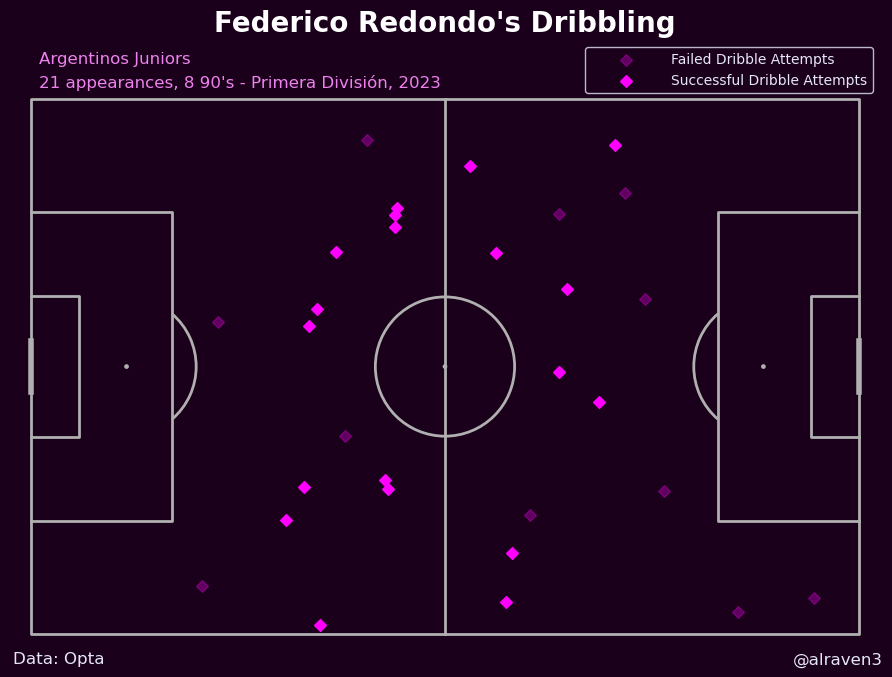

In [78]:
# Initialize the pitch
pitch = Pitch(pitch_type='opta', pitch_color='#1a001a',pad_top=11)
fig, ax = pitch.draw(figsize=(13, 8), constrained_layout=True, tight_layout=False)

player_unsuccessful_dribbles = player_dribbles.loc[player_dribbles['outcomeType_displayName']=='Unsuccessful'].copy()
player_successful_dribbles = player_dribbles.loc[player_dribbles['outcomeType_displayName']=='Successful'].copy()
pitch.scatter(player_unsuccessful_dribbles.x, player_unsuccessful_dribbles.y, 
              marker='D',color='#ff00ff',alpha=.3,label='Failed Dribble Attempts',ax=ax)
pitch.scatter(player_successful_dribbles.x, player_successful_dribbles.y, 
              marker='D',color='#ff00ff',label='Successful Dribble Attempts',ax=ax)
# Legend and title
ax.legend(facecolor='#1a001a', edgecolor='lavender', labelcolor='lavender', fontsize=10, loc='upper right', handlelength=5)
fig.set_facecolor('#1a001a')
ax_title = ax.set_title(f"{player_name}'s Dribbling", fontsize=20, color='white',fontweight='bold')
fig.text(0.2, 0.85, f"{player_team}",color='violet',size=12)
fig.text(0.2, 0.82, f"{player_appearances} - {competition_date}",color='violet',size=12)
fig.text(0.78,0.1,'@alraven3',color='lavender',size=12)
fig.text(0.45,0.1,f"{data_valid}",color='lavender',size=12)
fig.text(0.18,0.1,'Data: Opta',color='lavender',size=12)

**Heatmaps**

Text(0.19, 0.1, 'Data: Opta')

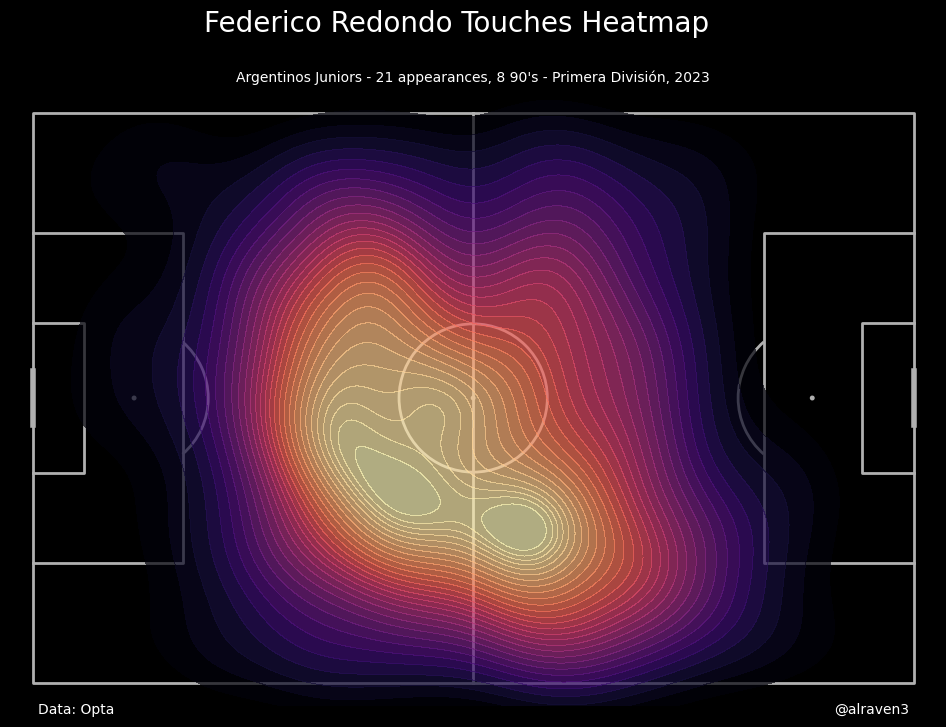

In [79]:
fig ,ax = plt.subplots(figsize=(13.5,8))

#this is how we create the pitch
pitch = Pitch(pitch_type='opta',pitch_color='#000000')

fig.set_facecolor('#000000')

#Draw the pitch on the ax figure as well as invert the axis for this specific pitch
pitch.draw(ax=ax)

#Create the heatmap
kde = sns.kdeplot(data=player_touches,
        x='x',
        y='y',
        fill = True,
        #shade_lowest=False,
        
        alpha=.7,
        n_levels=30,
        cmap='magma'
)

plt.suptitle(f"{player_name} Touches Heatmap",size=20,color='white')
plt.title(f"{player_team} - {player_appearances} - {competition_date}",size=10,color='white')
fig.text(0.78,0.1,'@alraven3',color='white')
fig.text(0.45,0.1,f"{data_valid}",color='white',size=12)
fig.text(0.19,0.1,'Data: Opta',color='white')

More heatmap/colormap customizations: https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_cmap.html#sphx-glr-gallery-pitch-plots-plot-cmap-py

https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_heatmap.html#sphx-glr-gallery-pitch-plots-plot-heatmap-py

Text(0.2, 0.05, 'Data: Opta')

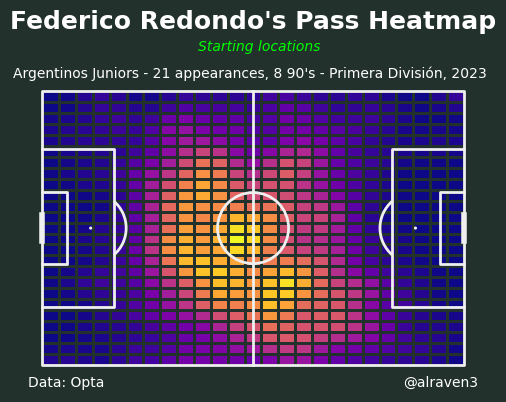

In [80]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
# Tom Decroos, author of `matplotsoccer <https://github.com/TomDecroos/matplotsoccer>`_,
# asked whether it was possible to plot a Gaussian smoothed heatmap,
# which are available in matplotsoccer. Here is an example demonstrating this.

# setup pitch
pitch = Pitch(pitch_type='opta', line_zorder=2,
              pitch_color='#22312b', line_color='#efefef',pad_top=20,pad_bottom=10)
# draw
fig, ax = pitch.draw(figsize=(7.5, 4.125))
fig.set_facecolor('#22312b')
bin_statistic = pitch.bin_statistic(player_passes.x, player_passes.y, statistic='count', bins=(25, 25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='plasma', edgecolors='#22312b')
# Add the colorbar and format off-white
#cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
#cbar.outline.set_edgecolor('#efefef')
#cbar.ax.yaxis.set_tick_params(color='#efefef')
#ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
ax_title = ax.set_title(f"{player_name}'s Pass Heatmap", fontsize=18,color='white',fontweight='bold')
x, y, text = 37, 115, "Starting locations"
ax.text(x, y, text,color='lime',style='italic')
fig.text(0.18, 0.8, f"{player_team} - {player_appearances} - {competition_date}",color='white')
fig.text(0.7,0.05,'@alraven3',color='white')
fig.text(0.4,0.05,f"{data_valid}",color='white')
fig.text(0.2,0.05,'Data: Opta',color='white')

Text(0.15, 0.02, 'Data: Opta')

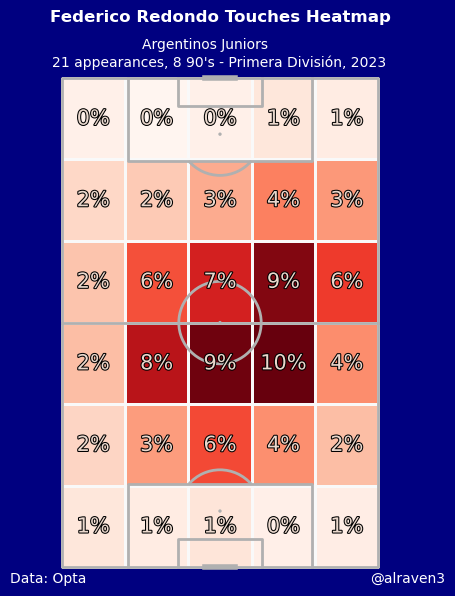

In [81]:
# path effects
import matplotlib.patheffects as path_effects
path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]

# see the custom colormaps example for more ideas on setting colormaps
pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#15242e', '#4393c4'], N=10)
pitch = VerticalPitch(pitch_type='opta', line_zorder=2, pitch_color='#000080',pad_top=15)
fig, ax = pitch.draw(figsize=(6, 6))
fig.set_facecolor('#000080')
bin_statistic = pitch.bin_statistic(player_touches.x, player_touches.y, statistic='count', bins=(6, 5), normalize=True)
pitch.heatmap(bin_statistic, ax=ax, cmap='Reds', edgecolor='#f9f9f9')
labels = pitch.label_heatmap(bin_statistic, color='#ead8cd', fontsize=15,
                             ax=ax, ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)
ax.set_title(f"{player_name} Touches Heatmap",color='white',fontweight='bold')
fig.text(0.37, 0.91, f"{player_team}",color='white')
fig.text(0.22, 0.88, f"{player_appearances} - {competition_date}",color='white')
fig.text(0.75,0.02,'@alraven3',color='white')
fig.text(0.4,0.02,f"{data_valid}",color='white')
fig.text(0.15,0.02,'Data: Opta',color='white')

Text(0.15, 0.02, 'Data: Opta')

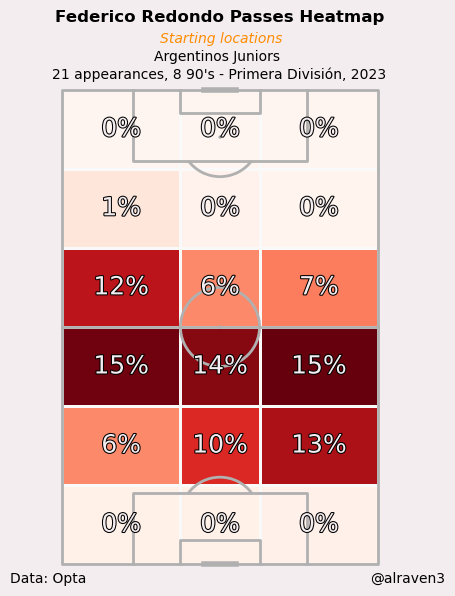

In [82]:
pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#f4edf0',pad_top=15)
fig, ax = pitch.draw(figsize=(6, 6))
fig.set_facecolor('#f4edf0')
bin_x = np.linspace(pitch.dim.left, pitch.dim.right, num=7)
bin_y = np.sort(np.array([pitch.dim.bottom, pitch.dim.six_yard_bottom,
                          pitch.dim.six_yard_top, pitch.dim.top]))
bin_statistic = pitch.bin_statistic(player_passes.x, player_passes.y, statistic='count',
                                    bins=(bin_x, bin_y), normalize=True)
pitch.heatmap(bin_statistic, ax=ax, cmap='Reds', edgecolor='#f9f9f9')
labels2 = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                              ax=ax, ha='center', va='center',
                              str_format='{:.0%}', path_effects=path_eff)
ax.set_title(f"{player_name} Passes Heatmap",color='black',fontweight='bold')
fig.text(0.4, 0.92, "Starting locations",color='darkorange',style='italic')
fig.text(0.39, 0.89, f"{player_team}",color='black')
fig.text(0.22, 0.86, f"{player_appearances} - {competition_date}",color='black')
fig.text(0.75,0.02,'@alraven3',color='black')
fig.text(0.4,0.02,f"{data_valid}",color='black')
fig.text(0.15,0.02,'Data: Opta',color='black')

https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_heatmap_positional.html#sphx-glr-gallery-pitch-plots-plot-heatmap-positional-py

Text(0.05, 0.9, "Argentinos Juniors - 21 appearances, 8 90's - Primera División, 2023")

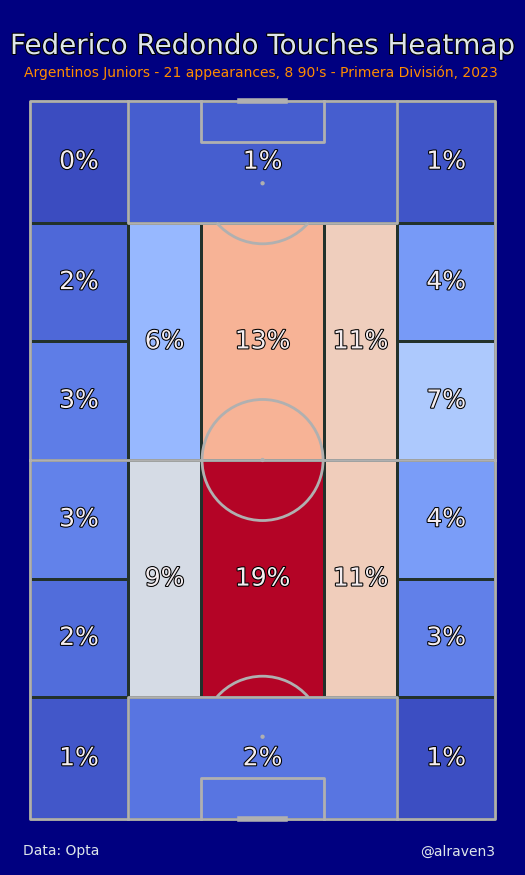

In [83]:
pitch = VerticalPitch(pitch_type='opta', line_zorder=2, pitch_color='#000080')
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)
fig.set_facecolor('#000080')

# heatmap and labels
bin_statistic = pitch.bin_statistic_positional(player_touches.x, player_touches.y, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap='coolwarm', edgecolors='#22312b')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

# endnote and title
axs['endnote'].text(1, 0.5, '@alraven3', va='center', ha='right', fontsize=10,color='#dee6ea')
axs['endnote'].text(0.15, 0.5, 'Data: Opta', va='center', ha='right', fontsize=10,color='#dee6ea')
axs['endnote'].text(0.65, 0.5, f"{data_valid}", va='center', ha='right', fontsize=10,color='#dee6ea')
axs['title'].text(0.5, 0.5, f"{player_name} Touches Heatmap", color='#dee6ea',
                  va='center', ha='center', path_effects=path_eff,fontsize=20)
fig.text(0.05, 0.9, f"{player_team} - {player_appearances} - {competition_date}",color='darkorange')


Text(0.05, 0.87, "Argentinos Juniors - 21 appearances, 8 90's - Primera División, 2023")

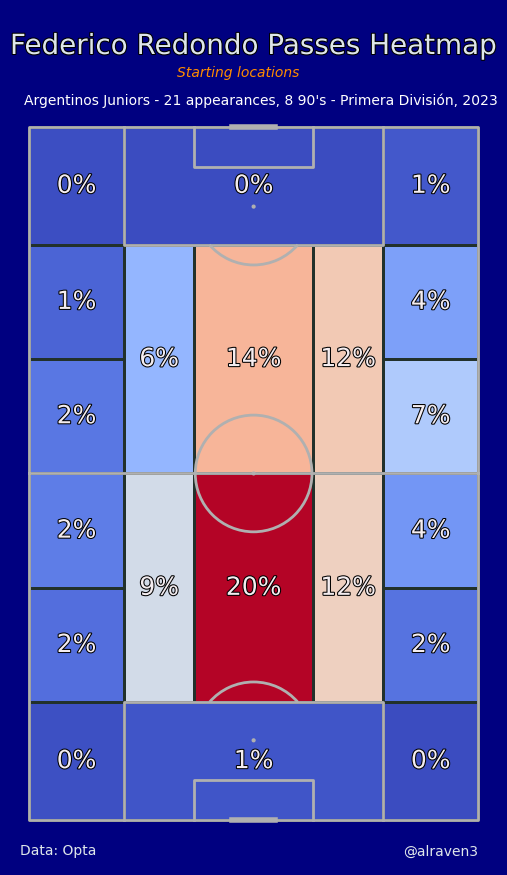

In [84]:
pitch = VerticalPitch(pitch_type='opta', line_zorder=2, pitch_color='#000080',pad_top=10)
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)
fig.set_facecolor('#000080')

# heatmap and labels
bin_statistic = pitch.bin_statistic_positional(player_passes.x, player_passes.y, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap='coolwarm', edgecolors='#22312b')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

# endnote and title
axs['endnote'].text(1, 0.5, '@alraven3', va='center', ha='right', fontsize=10,color='#dee6ea')
axs['endnote'].text(0.15, 0.5, 'Data: Opta', va='center', ha='right', fontsize=10,color='#dee6ea')
axs['endnote'].text(0.65, 0.5, f"{data_valid}", va='center', ha='right', fontsize=10,color='#dee6ea')
axs['title'].text(0.5, 0.5, f"{player_name} Passes Heatmap", color='#dee6ea',
                  va='center', ha='center', path_effects=path_eff,fontsize=20)
fig.text(0.35, 0.9, "Starting locations",color='darkorange',style='italic')
fig.text(0.05, 0.87, f"{player_team} - {player_appearances} - {competition_date}",color='white')

Text(0.05, 0.9, "Argentinos Juniors - 21 appearances, 8 90's - Primera División, 2023")

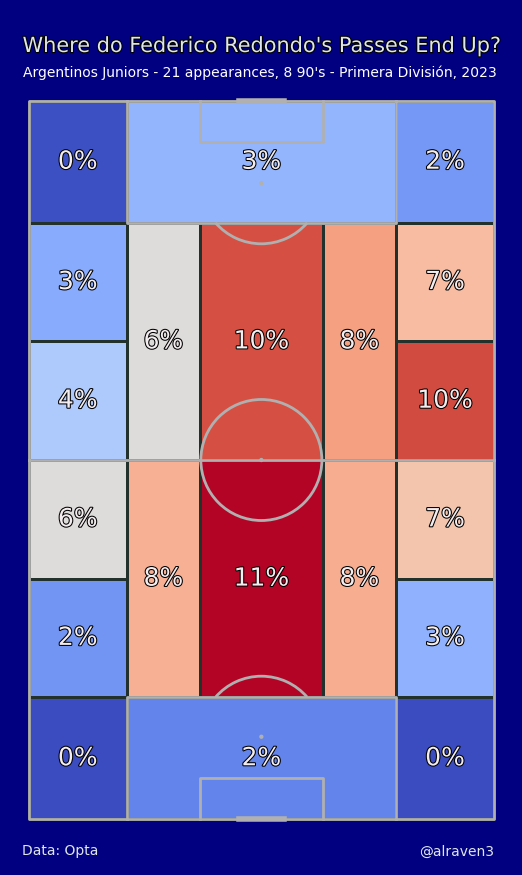

In [85]:
pitch = VerticalPitch(pitch_type='opta', line_zorder=2, pitch_color='#000080')
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)
fig.set_facecolor('#000080')

# heatmap and labels
bin_statistic = pitch.bin_statistic_positional(player_passes.endX, player_passes.endY, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap='coolwarm', edgecolors='#22312b')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

# endnote and title
axs['endnote'].text(1, 0.5, '@alraven3', va='center', ha='right', fontsize=10,color='#dee6ea')
axs['endnote'].text(0.15, 0.5, 'Data: Opta', va='center', ha='right', fontsize=10,color='#dee6ea')
axs['endnote'].text(0.65, 0.5, f"{data_valid}", va='center', ha='right', fontsize=10,color='#dee6ea')
axs['title'].text(0.5, 0.5, f"Where do {player_name}'s Passes End Up?", color='#dee6ea',
                  va='center', ha='center', path_effects=path_eff,fontsize=15)
fig.text(0.05, 0.9, f"{player_team} - {player_appearances} - {competition_date}",color='white')